In [5]:
import os
import re
from collections import defaultdict
from copy import copy

In [12]:
log_filename = "../simulation_results/hoya/nogrid_hoya_outputs.txt"
#dim = 10,10
#population_per_cell = 100
#population = dim[0] * dim[1] * population_per_cell
patt_out_line = "\{(?P<id>.*) ; <(?P<state>[\w,. -]+)>\}"

In [20]:
COLOR_SUSCEPTIBLE = "#3498db"
COLOR_INCUBATION = "#f1c40f"
COLOR_INFECTED = "#e74c3c"
COLOR_LATENT = "#c0392b"
COLOR_RECOVERED = "#2ecc71"
COLOR_DEAD = "#9b59b6"

In [42]:
def curr_states_to_df_row(sim_time, curr_states, num_inf, num_rec):
    sus_acc = 0
    inf_acc = 0
    rec_acc = 0
    #dth_acc = 0
    
    new_inf = 0
    new_rec = 0
    
    for k in curr_states:
        sus_acc += curr_states[k][0]
        inf_acc += sum(curr_states[k][1:num_inf+1])
        rec_acc += sum(curr_states[k][num_inf+1:num_inf+num_rec+1])
        #dth_acc += curr_states[k][num_inf+num_rec+1]

        new_inf += curr_states[k][1]
        new_rec += curr_states[k][num_inf+1]

        #print(sum(curr_states[k]), sus_acc, inf_acc, rec_acc, dth_acc)
        assert 0.999 <= sum(curr_states[k]) < 1.001, (curr_time, sum(curr_states[k]))
            
    num_cells = len(curr_states)
    sus_acc /= num_cells
    inf_acc /= num_cells
    rec_acc /= num_cells
    #dth_acc /= num_cells
    
    new_inf /= num_cells
    new_rec /= num_cells
    
    assert 0.999 <= sus_acc + inf_acc + rec_acc< 1.001, (curr_time, sus_acc, inf_acc, rec_acc)
    
    return [int(sim_time), sus_acc, inf_acc, rec_acc, new_inf, new_rec]

In [54]:
states = ["sus", "infec", "rec"]
data = []
curr_data = []
curr_time = None
curr_states = {}
num_inf = 0
num_rec = 0

with open(log_filename, "r") as log_file:
    for line in log_file:
        line = line.strip()
        if line.isnumeric() and line != curr_time:
            if curr_states:
                data.append(curr_states_to_df_row(curr_time, curr_states, num_inf, num_rec))
            curr_time = line
            continue

        match = re.search(patt_out_line, line)
        if not match:
            print(line)
            continue
            
        if not curr_states:
            sp = match.group("state").split(",")
            num_inf = int(sp[2])
            num_rec = int(sp[3])

        cid = match.group("id")
        state = list(map(float, match.group("state").split(",")[4:]))
        curr_states[cid] = state
        
    data.append(curr_states_to_df_row(curr_time, curr_states, num_inf, num_rec))

0


In [44]:
data[:3]

[[0, 0.9, 0.09999999999999999, 0.0, 0.09999999999999999, 0.0],
 [1,
  0.8913333333333333,
  0.10166666666666668,
  0.007,
  0.008666666666666666,
  0.007],
 [2,
  0.882,
  0.10366666666666668,
  0.014333333333333335,
  0.009333333333333332,
  0.007333333333333334]]

### Visualization

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [46]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [49]:
columns = ["time", "susceptible", "infected", "recovered", "new_infected", "new_recovered"]
df_vis = pd.DataFrame(data, columns=columns)
df_vis = df_vis.set_index("time")
df_vis.to_csv("states.csv")
df_vis.head()

,susceptible,infected,recovered,new_infected,new_recovered
time,,,,,
0,0.900000,0.100000,0.000000,0.100000,0.000000
1,0.891333,0.101667,0.007000,0.008667,0.007000
2,0.882000,0.103667,0.014333,0.009333,0.007333
3,0.872667,0.106000,0.021333,0.009333,0.007000
4,0.863333,0.108000,0.028667,0.009333,0.007333


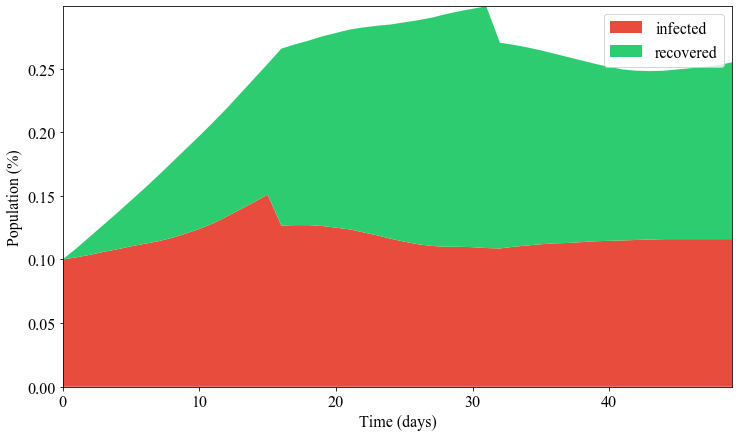

In [50]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["infected", "recovered"]
colors=[COLOR_INFECTED, COLOR_RECOVERED]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_area.pdf")
plt.savefig(base_name + "_area.png")

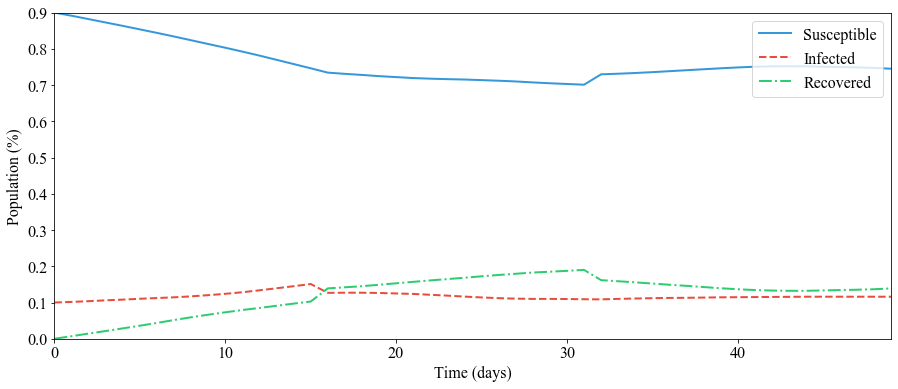

In [51]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
#ax.plot(x, df_vis["deaths"], label="Deaths", color=COLOR_DEAD, linewidth=linewidth, linestyle=":")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
plt.savefig(base_name + "_lines.pdf")
plt.savefig(base_name + "_lines.png")

Text(0, 0.5, 'Population (%)')

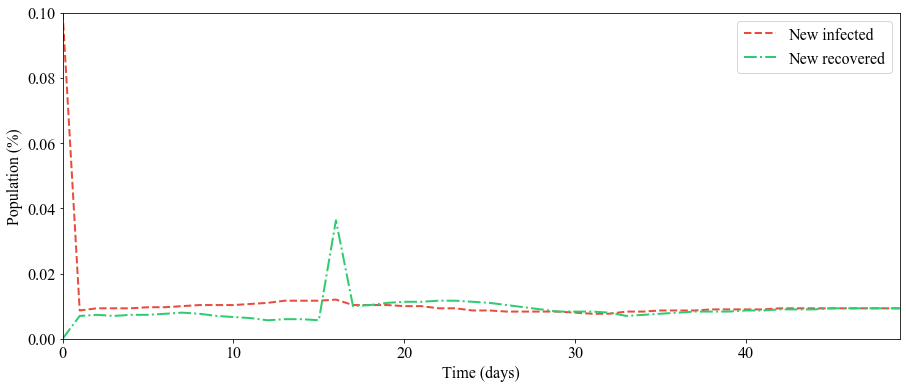

In [53]:
fig, ax = plt.subplots(figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["new_infected"], label="New infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
ax.plot(x, df_vis["new_recovered"], label="New recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
plt.legend(loc='upper right')
plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.xlabel("Time (days)")
plt.ylabel("Population (%)")
#plt.savefig(base_name + "_lines.pdf")

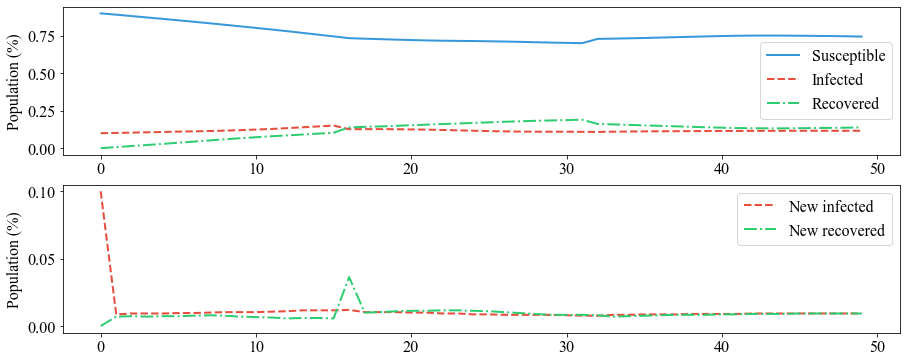

In [52]:
fig, axs = plt.subplots(2, figsize=(15,6))
linewidth = 2

x = list(df_vis.index)
axs[0].plot(x, df_vis["susceptible"], label="Susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
axs[0].plot(x, df_vis["infected"], label="Infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
axs[0].plot(x, df_vis["recovered"], label="Recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
axs[0].set_ylabel("Population (%)")
axs[0].legend()

axs[1].plot(x, df_vis["new_infected"], label="New infected", color=COLOR_INFECTED, linewidth=linewidth, linestyle="--")
axs[1].plot(x, df_vis["new_recovered"], label="New recovered", color=COLOR_RECOVERED, linewidth=linewidth, linestyle="-.")
axs[1].set_ylabel("Population (%)")
axs[1].legend()

#axs[2].plot(x, df_vis["deaths"], label="Deaths", color=COLOR_DEAD, linewidth=linewidth, linestyle=":")
#axs[2].set_xlabel("Time (days)")
#axs[2].set_ylabel("Population (%)")
#axs[2].legend()

#plt.margins(0,0)
#plt.title('Epidemic percentages (%s)' % base_name)
plt.savefig(base_name + "_lines_with_news.pdf")
plt.savefig(base_name + "_lines_with_news.png")

#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc=(0.808,0.295))